# Moral-Inference Project Continue

We will pick up from where we left, doing the tasks right after the autoencoder-with-BERT architecture. 

- Auto-encoder only baseline
- Fine-tuned BERT with auto-encoder baseline

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import random
from collections import defaultdict

In [2]:
full_data_path = "..//data//moral_data_full.json"

# Full_data is a dictionary
with open(full_data_path, 'r') as f:
    full_data = json.load(f)

In [4]:
moral_dialogue = full_data['moral_dialogue']
moral_dialogue_masked = full_data['moral_dialogue_masked']
ground_truths = full_data["ground_truths"]

### Auto-encoder only baseline

The input_dim is picked according to the size of the BERT embedding. We only create 2 layers for each encoder and decoder since the task is to find a low-dimensional bottleneck that captures moral traits (not learn basic features from scratch as in images and raw text).

Because all we can do is to train the parameters based on the reconstruction loss, we can not use the one-hot encoding.

In [13]:
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

In [10]:
from transformers import BertTokenizer, BertModel
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

Using device: cpu


Process the dataset:


In [16]:
data = []

for movie, characters in tqdm(moral_dialogue.items(), desc= "Processing Characters"):
    for character, sentences in characters.items():
        # Only include characters with 100+ sentences
        if len(sentences) < 100:
            continue

        # Represent the character by the average of their sentences embeddings
        # We use return_tensors = 'pt' to get PyTorch tensors because Transformer models expect them
        with torch.no_grad():
            encoded = tokenizer(
                sentences, 
                return_tensors = 'pt',
                padding = True,
                truncation = True,
                max_length = 512
            )

            output = bert_model(**encoded)
            # Mean pooling
            sentence_embeddings = output.last_hidden_state.mean(dim=1)
            # Get the average of the sentence embeddings
            avg_embedding = sentence_embeddings.mean(dim=0).cpu()
        
        data.append((movie, character, avg_embedding))

Processing Characters: 100%|██████████| 1072/1072 [29:23<00:00,  1.65s/it] 


In [27]:
model_H = Autoencoder(input_dim=768, latent_dim=20).to(device)
num_epochs = 100 
lr = 1e-3
optimizer = torch.optim.Adam(model_H.parameters(), lr=lr)
total_loss_list = []
use_vae = False

In [28]:
for epoch in range(num_epochs):
    total_loss = 0
    for batch in data:
        if not batch:
            continue

        char_vec = batch[2].to(device)
        
        if use_vae:
            recon_vec, mu, logvar, z = model_H(char_vec)
            recon_loss = nn.MSELoss()(recon_vec, char_vec)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / char_vec.size(0)
            loss = recon_loss + kl_div
        else:
            recon_vec, z = model_H(char_vec)
            loss = nn.MSELoss(reduction = "mean")(recon_vec, char_vec)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    # Keep tracking the loss for each epoch
    total_loss_list.append(total_loss)

    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")


Epoch 1: Loss = 2.0055
Epoch 2: Loss = 0.6680
Epoch 3: Loss = 0.5044
Epoch 4: Loss = 0.4546
Epoch 5: Loss = 0.4065
Epoch 6: Loss = 0.3642
Epoch 7: Loss = 0.3360
Epoch 8: Loss = 0.3223
Epoch 9: Loss = 0.2977
Epoch 10: Loss = 0.2723
Epoch 11: Loss = 0.2656
Epoch 12: Loss = 0.2401
Epoch 13: Loss = 0.2388
Epoch 14: Loss = 0.2380
Epoch 15: Loss = 0.2340
Epoch 16: Loss = 0.2265
Epoch 17: Loss = 0.2152
Epoch 18: Loss = 0.2015
Epoch 19: Loss = 0.1925
Epoch 20: Loss = 0.1917
Epoch 21: Loss = 0.1918
Epoch 22: Loss = 0.1953
Epoch 23: Loss = 0.1954
Epoch 24: Loss = 0.1810
Epoch 25: Loss = 0.1791
Epoch 26: Loss = 0.1860
Epoch 27: Loss = 0.1779
Epoch 28: Loss = 0.1636
Epoch 29: Loss = 0.1664
Epoch 30: Loss = 0.1695
Epoch 31: Loss = 0.1714
Epoch 32: Loss = 0.1777
Epoch 33: Loss = 0.1717
Epoch 34: Loss = 0.1588
Epoch 35: Loss = 0.1641
Epoch 36: Loss = 0.1552
Epoch 37: Loss = 0.1670
Epoch 38: Loss = 0.1464
Epoch 39: Loss = 0.1526
Epoch 40: Loss = 0.1463
Epoch 41: Loss = 0.1514
Epoch 42: Loss = 0.1460
E

Let's plot how the loss decreases across epochs

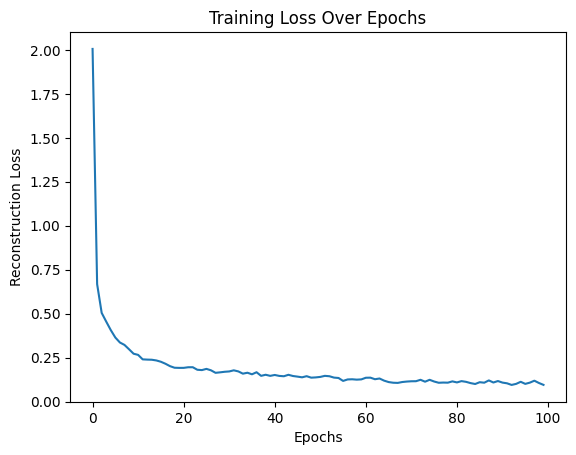

In [29]:
plt.plot(total_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [32]:
for row in data:
    movie = row[0]
    character = row[1]
    print("Movie: ", movie, " -- Character: ", character)

Movie:  1492: Conquest of Paradise  -- Character:  COLUMBUS
Movie:  30 Minutes or Less  -- Character:  WILL
Movie:  50-50  -- Character:  ADAM
Movie:  500 Days of Summer  -- Character:  TOM
Movie:  8MM  -- Character:  WELLES
Movie:  A Few Good Men  -- Character:  KAFFEE
Movie:  A Most Violent Year  -- Character:  ABEL
Movie:  A Serious Man  -- Character:  LARRY
Movie:  Ace Ventura: Pet Detective  -- Character:  ACE
Movie:  Adaptation  -- Character:  KAUFMAN
Movie:  Adjustment Bureau, The  -- Character:  DAVID
Movie:  Agnes of God  -- Character:  MARTHA
Movie:  All About Eve  -- Character:  MARGO
Movie:  All About Steve  -- Character:  MARY
Movie:  All the King's Men  -- Character:  WILLIE
Movie:  Amadeus  -- Character:  MOZART
Movie:  Amelia  -- Character:  AMELIA
Movie:  American Hustle  -- Character:  IRVING ROSENFELD
Movie:  American President, The  -- Character:  SHEPHERD
Movie:  American Psycho  -- Character:  BATEMAN
Movie:  Analyze That  -- Character:  BEN
Movie:  Analyze This  

Let's analyze the latent embeddings using PCA and t-SNE

In [35]:
char_embeddings = {}
for row in data:
    movie = row[0]
    character = row[1]
    # Get the latent embedding
    _, latent_embedding = model_H(row[2])
    char_movie_name = f"{movie}_{character}"
    char_embeddings[char_movie_name] = latent_embedding

In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Step 1: Define anchor characters
anchor_names = [
    "Gandhi_GANDHI",
    "American Psycho_BATEMAN",
    "Forrest Gump_FORREST",
    "Fight Club_TYLER",
    "Erin Brockovich_ERIN",
    "Wolf of Wall Street, The_JORDAN",
    "Django Unchained_DJANGO",
    "Scarface_TONY",
    "Shawshank Redemption, The_RED",
    "Departed, The_COLIN"
]

all_embeddings = torch.stack([char_embeddings[c] for c in char_embeddings])  # shape (n_char, latent_dim)
char_names = list(char_embeddings.keys())

# Step 3: PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_embeddings.detach().numpy())

# Step 4: t-SNE
tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
tsne_result = tsne.fit_transform(all_embeddings.detach().numpy())

In [46]:
def plot_result(result, title, anchor_names):
    # Step 5: Plot
    plt.figure(figsize=(10, 8))
    for i, name in enumerate(char_names):
        x, y = result[i]
        if name in anchor_names:
            plt.scatter(x, y, c='red')
            plt.text(x, y, name, fontsize=9)
        else:
            plt.scatter(x, y, c='gray', alpha=0.3)
    plt.title(title)
    plt.show()

t-SNE

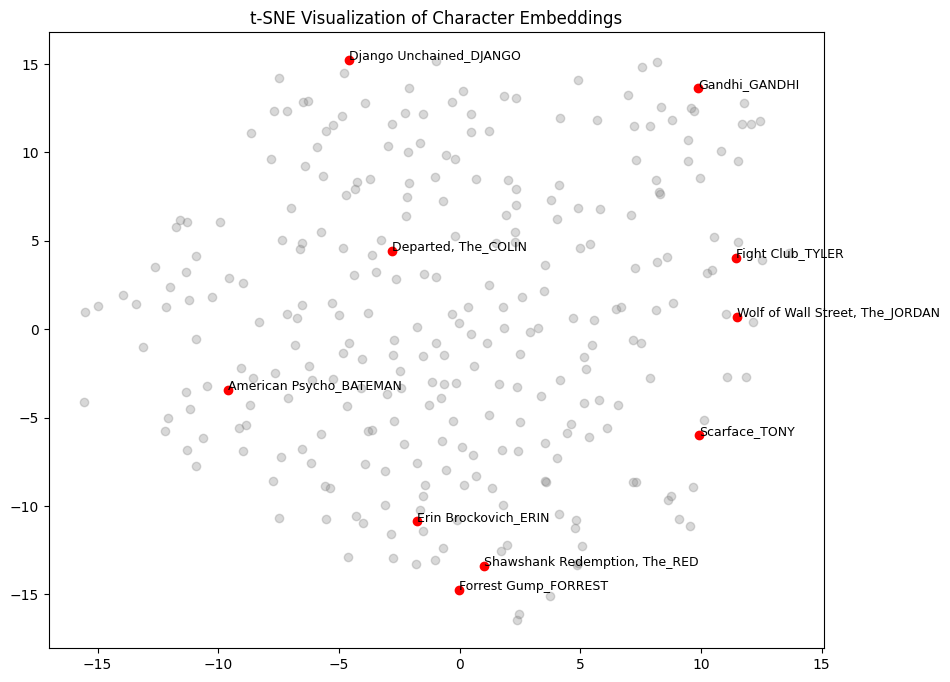

In [48]:
plot_result(tsne_result, "t-SNE Visualization of Character Embeddings", anchor_names)

PCA

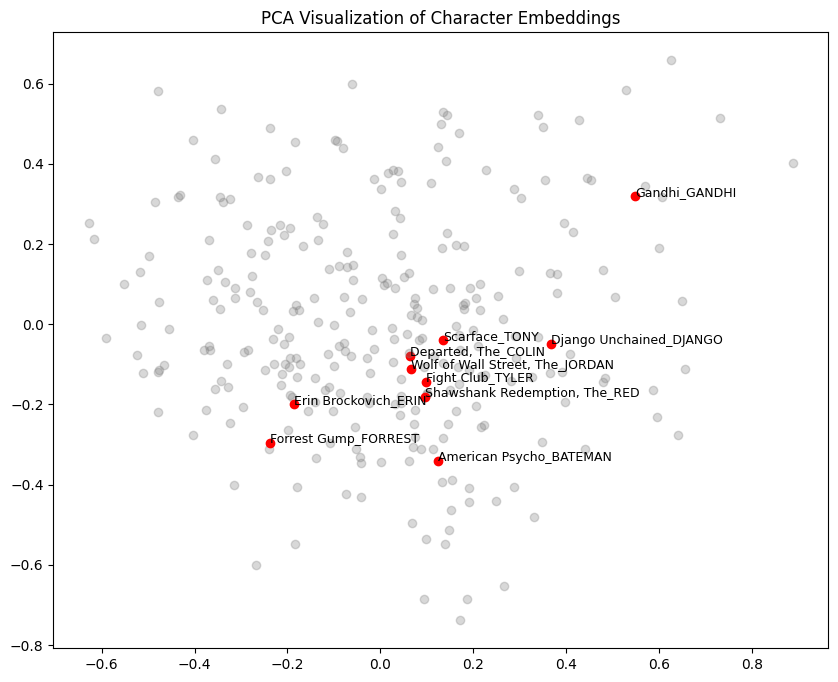

In [49]:
plot_result(pca_result, "PCA Visualization of Character Embeddings", anchor_names)

### BERT fine-tuned baseline (with autoencoder)

We will first focus on the trained BERT + trained autoencoder architcture . Then we can try re-doing the BERT only baseline model if needed (if the existing trained model is not comparable to the other models)



In [54]:
from transformers import BertForMaskedLM

bertmaskedLM = BertForMaskedLM.from_pretrained('bert-base-uncased')

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

In [56]:
for name, param in bert_model.named_parameters():
    print(name)

embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.layer.1.attention.self.key

In [55]:
for name, param in bertmaskedLM.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [15]:
import json

with open("..//data//morality_check_gpt4omini.json", 'r') as f:
    moral_check = json.load(f)

moral_check.keys()

dict_keys(['1492: Conquest of Paradise', '30 Minutes or Less', '50-50', '500 Days of Summer', '8MM', 'A Few Good Men', 'A Most Violent Year', 'A Serious Man', 'Ace Ventura: Pet Detective', 'Adaptation', 'Adjustment Bureau, The', 'Agnes of God', 'All About Eve', 'All About Steve', "All the King's Men", 'Amadeus', 'Amelia', 'American Hustle', 'American President, The', 'American Psycho', 'Analyze That', 'Analyze This', 'Angel Eyes', 'Annie Hall', 'Apartment, The', 'Apt Pupil', 'Arsenic and Old Lace', 'Arthur', 'August: Osage County', 'Back-up Plan, The', 'Bad Teacher', 'Bamboozled', 'Barry Lyndon', 'Basic', 'Being Human', 'Believer, The', 'Big Eyes', 'Big Fish', 'Big Lebowski, The', 'Big Sick, The', 'Blind Side, The', 'Blow', 'Body of Evidence', 'Bottle Rocket', 'Bounty Hunter, The', 'Boyhood', 'Bridesmaids', 'Broadcast News', 'Bruce Almighty', 'Buried', 'Burning Annie', 'Butterfly Effect, The', 'Cable Guy', 'Capote', 'Casino', 'Cast Away', 'Catch Me If You Can', 'Cedar Rapids', 'Change-

In [22]:
num_yes = 0
num_no = 0

for movie, characters in moral_check.items():
    for character, sentences in characters.items():
        for i, sentence in enumerate(sentences):
            if sentence == "yes":
                num_yes += 1
            elif sentence == "no":
                num_no += 1

print(f"Number of 'yes' responses: {num_yes}")
print(f"Number of 'no' responses: {num_no}")

Number of 'yes' responses: 9899
Number of 'no' responses: 27036


In [24]:
import json

with open("..//data//moral_only_data.json", 'r') as f:
    moral_only_data = json.load(f)

with open("..//data//non_moral_data.json", 'r') as f:
    non_moral_data = json.load(f)

In [26]:
import matplotlib.pyplot as plt

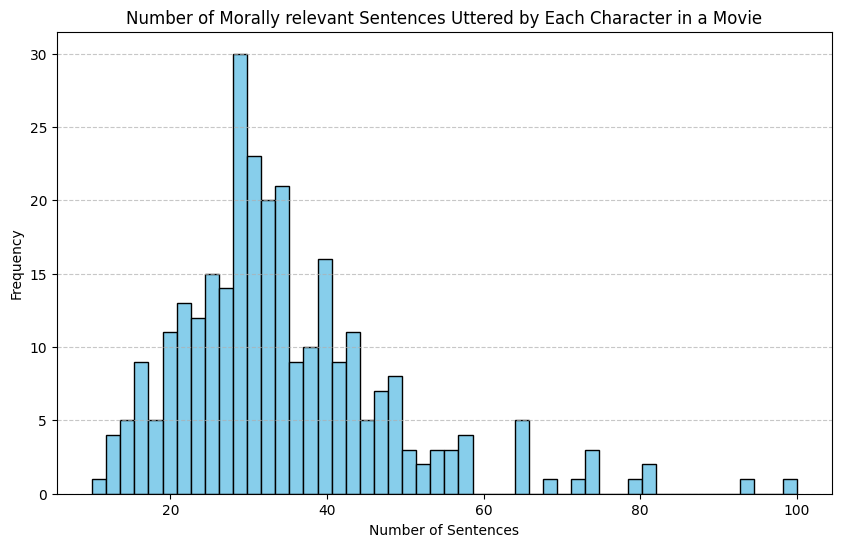

In [34]:
character_sentence_count = [
    len(sentences) 
    for movie, characters in moral_only_data["moral_dialogue"].items()
    for character, sentences in characters.items()
]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(character_sentence_count, bins=50, edgecolor='black', color='skyblue')
plt.title('Number of Morally relevant Sentences Uttered by Each Character in a Movie')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Show the plot
plt.savefig('..//data//histogram_2.png')
plt.show()

In [44]:
character_sentence_count = [
    (movie, character)
    for movie, characters in moral_only_data["moral_dialogue"].items()
    for character, sentences in characters.items()
    if len(sentences) < 20
]

for movie, character in character_sentence_count:
    print(f"Movie: {movie} / Character: {character}")

Movie: Ace Ventura: Pet Detective / Character: ACE
Movie: Amadeus / Character: MOZART
Movie: Big Eyes / Character: WALTER
Movie: Boyhood / Character: DAD
Movie: Crazylove / Character: LETTY
Movie: Deception / Character: JONATHAN
Movie: Departed, The / Character: COLIN
Movie: Fabulous Baker Boys, The / Character: FRANK
Movie: Jay and Silent Bob Strike Back / Character: JAY
Movie: Man Trouble / Character: HARRY
Movie: Manhattan Murder Mystery / Character: CAROL
Movie: Midnight in Paris / Character: GIL
Movie: Never Been Kissed / Character: JOSIE
Movie: Notting Hill / Character: WILLIAM
Movie: One Flew Over the Cuckoo's Nest / Character: MCMURPHY
Movie: Pineapple Express / Character: SAUL
Movie: Pretty Woman (final script) / Character: EDWARD
Movie: Saving Mr. Banks / Character: PAMELA
Movie: Secret Life of Walter Mitty, The / Character: WALTER
Movie: Semi-Pro / Character: JACKIE MOON
Movie: Sherlock Holmes / Character: HOLMES
Movie: Sideways / Character: MILES
Movie: Sunset Blvd. / Chara

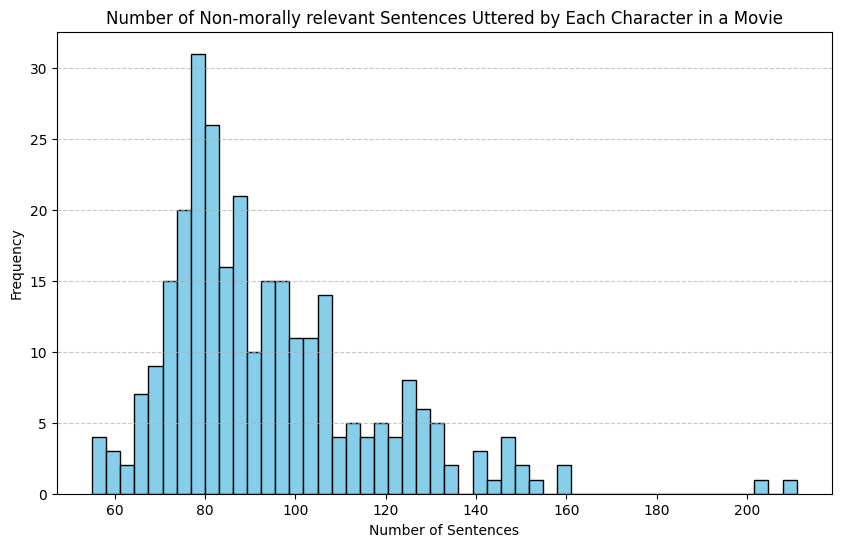

In [33]:
character_sentence_count = [
    len(sentences) 
    for movie, characters in non_moral_data["moral_dialogue"].items()
    for character, sentences in characters.items()
]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(character_sentence_count, bins=50, edgecolor='black', color='skyblue')
plt.title('Number of Non-morally relevant Sentences Uttered by Each Character in a Movie')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Show the plot
plt.savefig('..//data//histogram_2.png')
plt.show()